# Fake News Analysis of Tweets

*Dataset used: [The TruthSeeker Dataset](https://www.unb.ca/cic/datasets/truthseeker-2023.html) ([Kaggle](https://www.kaggle.com/datasets/sudishbasnet/truthseekertwitterdataset2023))*

In [65]:
from pathlib import Path

if Path.cwd().name == 'notebooks':
    %cd ..

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import spacy as sp
from collections import Counter
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from scipy.stats import mannwhitneyu

nlp = sp.load('en_core_web_sm')
nltk.download('vader_lexicon')

rng = np.random.default_rng(42)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ivan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Introduction

This notebook performs various forms of natural language processing on a large dataset of tweets labeled for truth. I'm hoping to determine differences in language and expression between true and false tweets and the relationship between truth, tweet sentiment, and user influence.

In [66]:
data_directory = Path.cwd() / 'data'
print(f'Data directory: {data_directory}')
preprocessed_loc = data_directory / 'preprocessed_dataset.parquet'
if preprocessed_loc.exists():  # Already have preprocessed data, so load that instead
    df = pd.read_parquet(preprocessed_loc)
else:  # Construct a DataFrame for some preprocessing. The data for this is not available in the version uploaded to GitHub due to storage limitations.
    data_loc = data_directory / 'truthseeker-2023/Truth_Seeker_Model_Dataset.csv'
    analysis_data = data_directory / 'truthseeker-2023/Twitter_Analysis.csv'
    
    df = pd.read_csv(data_loc, index_col=0)
    df.drop(columns=['author', 'statement', 'target', 'BinaryNumTarget', 'manual_keywords', '5_label_majority_answer', '3_label_majority_answer'], inplace=True)
    df_analysis = pd.read_csv(analysis_data, index_col=0)
    df['tweet_truth'] = df_analysis.majority_target
    df['favorites'] = df_analysis.favourites
    df['normalized_influence'] = df_analysis.normalize_influence
df

Data directory: /Users/ivan/src/twitter-fake-news/data


,tweet,lemmatized_tweet,tweet_truth,favorites,normalized_influence
0,@POTUS Biden Blunders - 6 Month Update\n\nInfl...,biden blunders 6 month update inflation delta ...,True,10.0,0.104602
1,@S0SickRick @Stairmaster_ @6d6f636869 Not as m...,people literally starve street 19th century no...,True,1.0,0.094436
2,THE SUPREME COURT is siding with super rich pr...,supreme court side super rich property owner p...,True,0.0,0.039846
3,@POTUS Biden Blunders\n\nBroken campaign promi...,biden blunders break campaign promise inflatio...,True,0.0,0.104602
4,@OhComfy I agree. The confluence of events rig...,agree confluence event right unprecedented afg...,True,1.0,0.061135
...,...,...,...,...,...
134193,Joe Biden's family owned African slaves....\n\...,joe biden family own african slave joe biden g...,False,2.0,0.098915
134194,"Joe Bidens great, great grandfather was a slav...",joe bidens great great grandfather slave owner...,False,1.0,0.096203
134195,"@ChevyChaseToGo ""Joe Bidens great-grandfather ...",joe bidens great grandfather joseph j. biden 1...,False,0.0,0.076870
134196,@JoeBiden Facts are Bidens VP Kamala Harris Gr...,fact bidens vp kamala harris great great grand...,False,0.0,0.024038


This dataset is a large collection of tweets, each associated with a statement (omitted from the preprocessed dataset to minimize file size) known to be either true or false. Tweets were labeled as true or false by turkers who were asked if the tweet agrees with the statement. A tweet was assigned the same truth value as the statement if it agreed with the statement, and a tweet was assigned the opposite of the truth value of the statement if it disagreed. Because of this method, truth labels in the dataset are less likely to be biased (because all the labelers are asked is if the tweet agrees with a statement), but there may be some issues with the tweets labeled as true. Just because a tweet disagrees with a false statement does not mean it is true: it could be spreading some fake news of its own.

The dataset also has some additional analysis information about the tweets and users, including the number of favorites (i.e., likes) the tweet has and the normalized user influence score for the user that tweeted that tweet.

Here are the tweet counts for this dataset:

In [67]:
print(f'Number of true tweets: {df.tweet_truth.sum()}')
print(f'Number of false tweets: {df.tweet_truth.count() - df.tweet_truth.sum()}')
print(f'Number of tweets: {df.tweet_truth.count()}')

Number of true tweets: 68985
Number of false tweets: 65213
Number of tweets: 134198


## Lemmatization

Before doing most of the analyses in this notebook, the text must be lemmatized. Lemmatization is reducing each word in a text to its base form. For example, "geese" would be turned into "goose," "kicked" would be turned into "kick," and "his" would be turned into "he." We also need to perform tokenization (separating a text out into each of its semantically-relevant components) and stop word removal to do this. The following code performs lemmatization on every single tweet. To reduce runtime of the notebook, the output of this was saved along with the data as a Parquet file.

In [68]:
if 'lemmatized_tweet' not in df.columns:
    # Perform the lemmatization.
    # This is a fairly complicated comprehension, so I'll break it down:
    #     The outer list comprehension runs through each document after it has been processed by spaCy (the nlp.pipe generator
    #         will perform the natural language processing concurrently over multiple processes and return results as they come in.
    #     The generator comprehension inside ' '.join() loops over reach token in the document, excluding stop words, punctuation,
    #         spaces, and Twitter handles. It gets the lemma of each token for the join function to join.
    df['lemmatized_tweet'] = [' '.join(tok.lemma_ for tok in doc if not (tok.is_stop or tok.is_punct or tok.is_space or tok.text.startswith('@'))).lower() for doc in nlp.pipe(df.tweet, batch_size=50, n_process=-1)]
    df.to_parquet(preprocessed_loc, index=False)  # Save to a file. Parquet files are very space-efficient.

In [69]:
# Make sure there are no missing values
assert (~df.isna()).all().all(), 'Missing values detected'

## Analysis 1: Zipf's law graph

Part of Zipf's law is that a log-log plot of word frequency against frequency rank will produce a trend close to a straight line. The following visualization demonstrates the law and shows the most common words.

In [70]:
# This is a generator comprehension representing nested for loops--the left for loop is on the outside, and the right for loop is
# on the inside. We loop over each lemmatized token in each tweet and pass it to a Counter to count the occurences of each word.
word_counter = Counter(word for tweet in df.lemmatized_tweet for word in tweet.split(' '))
common_words, common_counts = zip(*word_counter.most_common(100))  # Get the 100 most common words

Here we can see that the three most common words are "trump" (most likely referring to Donald Trump), "people," and "biden" (referring to President Joe Biden). Looking through these words, it's clear that U.S. politics is a common topic in this dataset, along with the COVID-19 pandemic, race, and economics. This is likely due to the creators of the dataset intentionally choosing datasets that best demonstrate real/fake news and the prevalence of these topics in discussion nowadays (this dataset was created in 2023).

Now for the Zipf's Law graph:

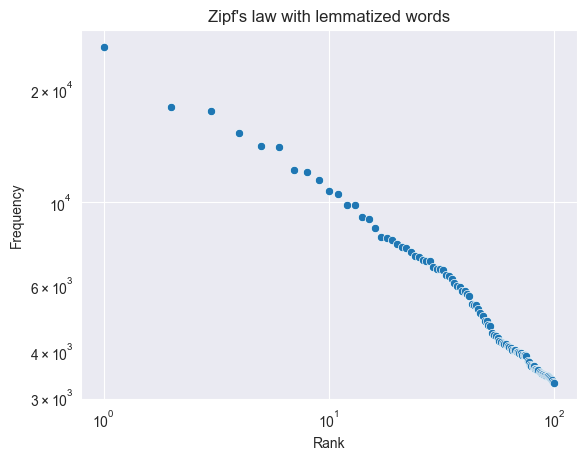

In [71]:
fig, ax = plt.subplots()
sns.scatterplot(x=np.arange(len(common_counts)) + 1, y=common_counts, ax=ax)
ax.set_xlabel('Rank')
ax.set_xscale('log')
ax.set_ylabel('Frequency')
ax.set_yscale('log')
ax.set_title('Zipf\'s law with lemmatized words')
plt.show()

A straight line appears, as expected.

## Analysis 2: Truth association

Now I will begin to analyze the differences in language between true and false tweets.

For some of these analyses, each tweet needs to be assigned a vector based on the terms in the tweet. There are multiple types of vectorizers that can be used, but a common one is the tf-idf vectorizer. Essentially, each term is given a score of relevance to each tweet, and those term vectors are put into the columns of a matrix to create a linear transformation from terms to documents.

In [72]:
vectorizer = TfidfVectorizer()
tweet_term_matrix = vectorizer.fit_transform(df.lemmatized_tweet)

tweet_term_matrix

<134198x56250 sparse matrix of type '<class 'numpy.float64'>'
	with 2200400 stored elements in Compressed Sparse Row format>

We store the tweet-term matrix in a sparse format because many of the entries in the tweet vectors are 0.

The purpose of this first truth analysis is to see which words are more associated with true tweets and which words are more associated with false tweets. Recall that the tweet-term matrix, which I will now denote with $X$, is constructed by putting term vectors $\mathbf{t}_i$ in the columns of $X$:
$
\begin{bmatrix}
\mathbf{t}_1 & \mathbf{t}_2 & \cdots & \mathbf{t}_n
\end{bmatrix}
$

Using the data about tweet truth, we can also construct a tweet-true column vector $\mathbf{T}$ and a tweet-false column vector $\mathbf{F}$ where each row contains a 1 if the corresponding tweet matches the truth value of the vector and a 0 if it does not. We want to represent the true and false vectors in terms of terms instead of tweets.

To do this, we compute the matrix transpose of the tweet-term matrix
$
X^{\top}
= \begin{bmatrix}
\mathbf{t}_1^{\top} \\
\mathbf{t}_2^{\top} \\
\vdots \\
\mathbf{t}_n^{\top}
\end{bmatrix}
$
and then multiply on the right by either the true or false vector:
$
X^{\top}\mathbf{T}
= \begin{bmatrix}
\mathbf{t}_1^{\top} \\
\mathbf{t}_2^{\top} \\
\vdots \\
\mathbf{t}_n^{\top}
\end{bmatrix}
\mathbf{T}
= \begin{bmatrix}
\mathbf{t}_1^{\top}\mathbf{T} \\
\mathbf{t}_2^{\top}\mathbf{T} \\
\vdots \\
\mathbf{t}_n^{\top}\mathbf{T}
\end{bmatrix}
$ and $
X^{\top}\mathbf{F}
= \begin{bmatrix}
\mathbf{t}_1^{\top} \\
\mathbf{t}_2^{\top} \\
\vdots \\
\mathbf{t}_n^{\top}
\end{bmatrix}
\mathbf{F}
= \begin{bmatrix}
\mathbf{t}_1^{\top}\mathbf{F} \\
\mathbf{t}_2^{\top}\mathbf{F} \\
\vdots \\
\mathbf{t}_n^{\top}\mathbf{F}
\end{bmatrix}
$
The entries of the resulting vectors contain the inner products between each term vector and the true/false vector. These inner products are equivalent to the scalar projections of the left vector onto the right vector. In other words, this matrix computation produces the association of each term to either truth or falsehood.

Performing an element-wise division of $X^{\top}\mathbf{T}$ over $X^{\top}\mathbf{F}$ produces a ratio comparing a term's relevance to true statements and its relevance to false statements. Computing the log of each ratio linearizes the metric, producing what I'm calling a **truth association score**. More positive scores indicate that term is more associated with true tweets, and more negative scores indicate that term is more associated with false tweets.

In [73]:
word_truth_associations = np.log(tweet_term_matrix.transpose().dot(df.tweet_truth.astype('float'))) - np.log(tweet_term_matrix.transpose().dot((~df.tweet_truth).astype('float')))
associations = pd.Series(word_truth_associations, index=vectorizer.get_feature_names_out(), name='associations')

associations

/var/folders/jn/m7m5vs8j7cx15w3sy62q6jsw0000gn/T/ipykernel_78985/1989981818.py:1: RuntimeWarning: divide by zero encountered in log
  word_truth_associations = np.log(tweet_term_matrix.transpose().dot(df.tweet_truth.astype('float'))) - np.log(tweet_term_matrix.transpose().dot((~df.tweet_truth).astype('float')))
/var/folders/jn/m7m5vs8j7cx15w3sy62q6jsw0000gn/T/ipykernel_78985/1989981818.py:1: RuntimeWarning: divide by zero encountered in log
  word_truth_associations = np.log(tweet_term_matrix.transpose().dot(df.tweet_truth.astype('float'))) - np.log(tweet_term_matrix.transpose().dot((~df.tweet_truth).astype('float')))


00          0.280881
000         0.164865
0000        2.104870
0000004          inf
0000007         -inf
              ...   
zyl              inf
zyrkon           inf
zzz              inf
zzzz        0.566624
zzzzzzzz        -inf
Name: associations, Length: 56250, dtype: float64

Notice how some of the values are infinite. This is because those particular terms only appear in either false statements ($-\infty$) or true statements ($+\infty$). For the sake of the next visualization, I'll be omitting these terms, in addition to terms that contain non-letter characters.

In [74]:
isalpha = np.vectorize(str.isalpha)  # This allows the isalpha function to be applied to numpy arrays efficiently
more_common_words = vectorizer.get_feature_names_out()[~np.isinf(word_truth_associations) & isalpha(vectorizer.get_feature_names_out())]
common_associations = word_truth_associations[~np.isinf(word_truth_associations) & isalpha(vectorizer.get_feature_names_out())]

Now equipped only with relatively common words and their truth association scores, we want to see what kind of words are most associated with true tweets or false tweets. For the visualization, I'm performing a uniform sample to make sure words in the visualization do not overlap.

Text(0.5, 1.0, 'Truth association score distribution in sample')

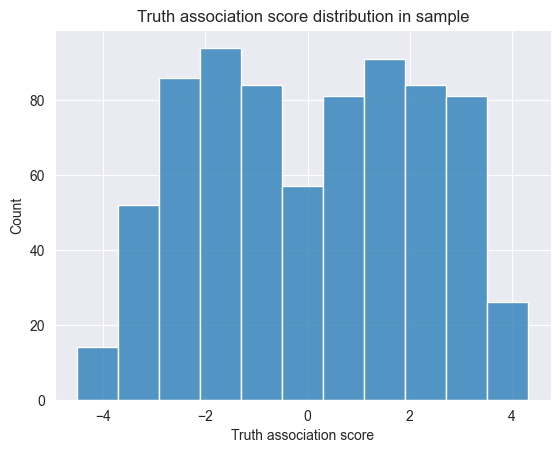

In [75]:
# Getting a roughly uniform random sample from the nonuniform distribution
# Based on the algorithm described here: https://cs.stackexchange.com/a/70680
sort_indices = np.argsort(common_associations)  # We need the terms to be sorted.
more_common_words = more_common_words[sort_indices]
common_associations = common_associations[sort_indices]
p = np.zeros_like(more_common_words, dtype='float64')  # Create a sampling probability for each entry
p[1:] = np.diff(common_associations)  # Probability of selection proportional to distance to previous word's truth association score
p[0] = p[1]
p **= 1.2  # Tuning parameter
p /= np.sum(p)  # Make into a probability distribution
sample = rng.choice(np.arange(len(more_common_words)), replace=False, size=750, p=p)

fig, ax = plt.subplots()
sns.histplot(common_associations[sample], ax=ax)
ax.set_xlabel('Truth association score')
ax.set_title('Truth association score distribution in sample')

To minimize overlapping of words, words will be assigned random y coordinates from 0 to 1 taken from a collection of evenly spaced coordinates from 0 to 1.

In [76]:
y_points = np.linspace(0, 1, len(common_associations))
rng.shuffle(y_points)

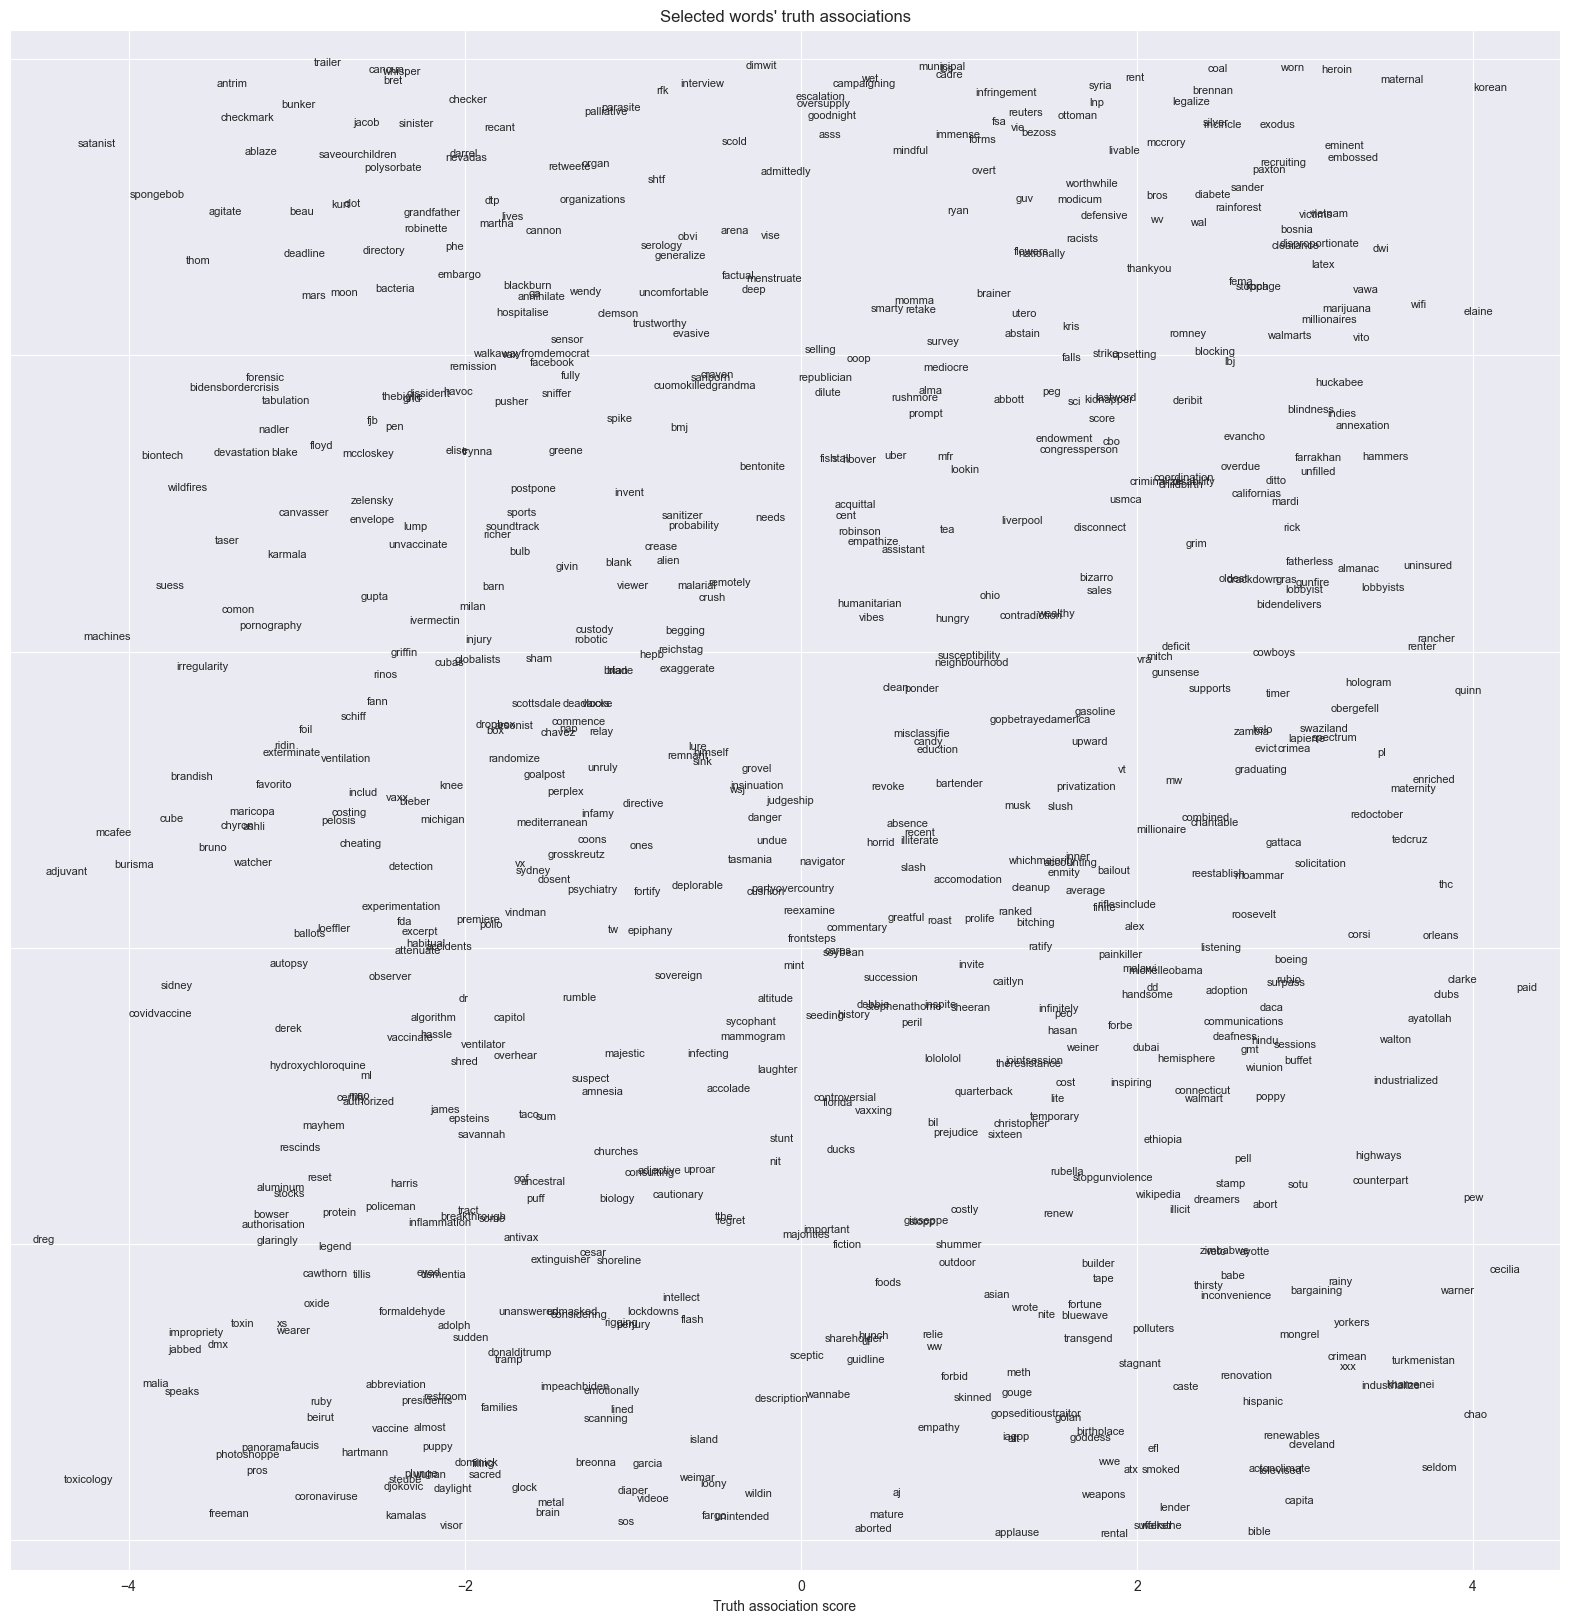

In [77]:
fig, ax = plt.subplots(figsize=(20, 20))
for word, x, y in zip(more_common_words[sample], common_associations[sample], y_points[sample]):
    ax.text(x, y, word, ha='center', va='center', fontsize=8)
ax.set_xlim(left=np.min(common_associations) - 0.2, right=np.max(common_associations) + 0.2)
ax.set_xlabel('Truth association score')
ax.set_ylim(bottom=np.min(y_points) - 0.02, top=np.max(y_points) + 0.02)
ax.tick_params(  # Removing y-axis labels since the y-axis is completely meaningless
    axis='y',
    which='both',
    bottom=False,
    top=False,
    labelleft=False
)
ax.set_title('Selected words\' truth associations')
plt.show()

I've added some hashtags in the following summary where they likely would have appeared in the original tweet.

Looking at words with especially negative words, many have to do recent political topics, especially when characterized in the form of conspiracy theories:

* covidvaccine, jabbed, experimentation, fda, biontech, ivermectin, hydroxychloroquine, vaxx, faucis, coronaviruse, adjuvant, bioweapon, naturalimmunity: Distrust of the COVID-19 vaccine, criticism of the handling of the COVID-19 pandemic by the DHHS, and unusual alternative treatments for COVID-19
* pornography: Panic over LGBTQ+ rights and representation
* irregularity, machines, ballots, cheating: Conspiracy theory that the 2020 U.S. Presidential Election was rigged
* #saveourchildren, satanist: QAnon (see [this](https://www.nbcnews.com/tech/tech-news/qanon-looms-behind-nationwide-rallies-viral-hashtags-n1237722) for more info)
* #bidensbordercrisis, robinette, kamalas, karmala, #impeachbiden, fjb: Criticism of the Biden administration
* epsteins: Epstein's island/list?

It's fairly obvious why these might be associated with false tweets: people who believe in conspiracy theories related to these topics are more likely to talk about them falsely.

The negative side also contains words that in general are more likely to cause alarm, such as "photoshoppe" and "exterminate." There are also some weirder words, such as "spongebob."

A few patterns also emerge from the true (positive) side:

* korean, turkmenistan, zambia, crimea, californias, syria, ghana, zimbabwe, malaysia: Countries, other geographic regions, and nationalities. This probably is associated with truth because, in general, a false statement is less likely to include location info because the individual spreading information probably lives there. Location information is also more likely to be used with news.
* #gopseditioustraitor, #republicansaretheproblem, #justicesuedtrump, #donthecon: Criticism of the GOP. It's interesting that Democratic viewpoints tend to be more true than Republican viewpoints in this dataset, however this may be less surprising considering that the GOP is currently, at least to some extent, supporting multiple known conspiracy theories. There also may be some bias in the data, since, without further context, it is difficult to believe that Democrats are much more truth-oriented than Republicans.
* barackobama, michelleobama, ilhan: Prominent members of the Democratic party.
* transgender, gay: LGBTQ+ identity. In general, statements of identity are more likely to be true because they are intrinsic characteristics of people. In addition, people who are anti-LGBTQ+ are less likely to affirm LGBTQ+ identity.

## Analysis 3: Fake news classifier

*Source: ["Apply a Simple Bag-of-Words Approach" on OpenClassrooms](https://openclassrooms.com/en/courses/6532301-introduction-to-natural-language-processing/8081284-apply-a-simple-bag-of-words-approach)*

One other interesting thing to do with the tweet-term matrix is to perform classification on true/false text to see if it *sounds* like fake news.

For this, I'm using a multinomial naive Bayes classifier. Recalling my previous assignment on Bayesian networks, naive Bayes is a Bayesian network where all observed variables have exactly one connection, which is to the response variable. In this case, the observed variable, word frequencies are assumed to be drawn from a multinomial distribution. Technically, a `CountVectorizer` should be used with this type of classifier, but others have shown that tf-idf still works quite well.

In [78]:
X_train, X_test, y_train, y_test = train_test_split(tweet_term_matrix, df.tweet_truth.astype('int'), test_size=0.33, random_state=42)

clf = MultinomialNB()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Accuracy: 0.9026554667389243


90% accuracy is amazing for a simple model like this. Now we can see if certain sentences sound like fake news:

In [79]:
def sounds_like_fake_news_proba(text: str) -> float:
    lemmas = ' '.join(tok.lemma_ for tok in nlp(text)).lower()
    return clf.predict_proba(vectorizer.transform([lemmas]))[0, 0]

sounds_like_fake_news_proba('Scientists have proven that vaccines cause autism')

0.901693532527937

For this sentence, the model did correctly identify that the statement is false. However, I should note that it is using exclusively diction to make that determination: it has no idea what the statement actually says.

Here's another example:

In [80]:
sounds_like_fake_news_proba('New scientific study shows that the COVID-19 vaccine is very effective against COVID-19')

0.8420414177857352

This identification was not correct. However, changing one word to make the statement false and running it again does give a correct result without much change in confidence:

In [81]:
sounds_like_fake_news_proba('New scientific study shows that the COVID-19 vaccine is not effective against COVID-19')

0.9017259142167454

This demonstrates that the model has little understanding of the statement itself. Here's another example that shows this:

In [82]:
print(f'True statement: {sounds_like_fake_news_proba('Scientists have shown that Ivermectin is ineffective against COVID-19')}')
print(f'False statement: {sounds_like_fake_news_proba('Scientists have shown that Ivermectin is effective against COVID-19')}')

True statement: 0.9466801277752576
False statement: 0.9049314629330644


One word that appears to have an effect on trustworthiness for this model is the word "proven." In both cases, use of "proven" increases its confidence that the statement is false, which makes sense because the misconception that scientists can "prove" conclusions like this is known to be used in fake news.

In [83]:
print(f'True-ish statement: {sounds_like_fake_news_proba('Scientists have proven that Ivermectin is ineffective against COVID-19')}')
print(f'False statement: {sounds_like_fake_news_proba('Scientists have proven that Ivermectin is effective against COVID-19')}')

True-ish statement: 0.9583058595121798
False statement: 0.9250271657715712


## Analysis 4: The effect of capital letters

One drawback of the system used in the previous section is that it doesn't account for capitalization. However, capitalization can be a significant indicator of tone. In this section I check if there is a link between increased use of capitals and truth/falsehood.

A good metric of capital use is the proportion of letters in each tweet that are capitalized. I calculate this here:

In [84]:
df['capital_ratio'] = df.tweet.apply(lambda tweet: len([char for char in tweet if char.isalpha() and char.isupper()]) / len([char for char in tweet if char.isalpha()]))

df.capital_ratio

0         0.147321
1         0.037975
2         0.174863
3         0.119469
4         0.066667
            ...   
134193    0.088000
134194    0.046875
134195    0.113208
134196    0.151376
134197    0.038462
Name: capital_ratio, Length: 134198, dtype: float64

Now let's plot the distributions using a kernel density estimate violin plot:

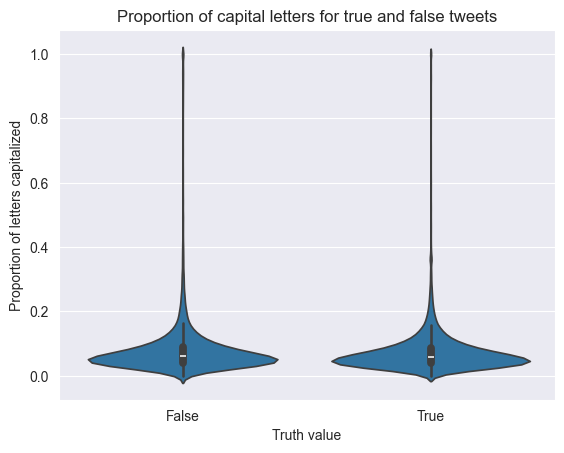

In [85]:
fig, ax = plt.subplots()
sns.violinplot(data=df, x='tweet_truth', y='capital_ratio', ax=ax)
ax.set_xlabel('Truth value')
ax.set_ylabel('Proportion of letters capitalized')
ax.set_title('Proportion of capital letters for true and false tweets')
plt.show()

There does not appear to be a very significant difference. Zooming in on the mode of both distributions yields this plot:

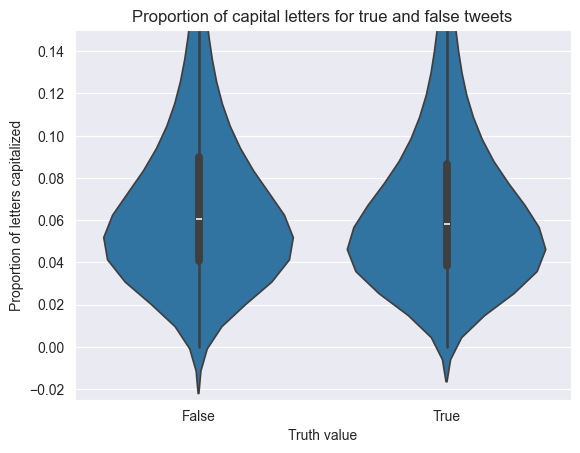

In [86]:
fig, ax = plt.subplots()
sns.violinplot(data=df, x='tweet_truth', y='capital_ratio', ax=ax)
ax.set_xlabel('Truth value')
ax.set_ylabel('Proportion of letters capitalized')
ax.set_ylim(bottom=-0.025, top=0.15)
ax.set_title('Proportion of capital letters for true and false tweets')
plt.show()

Using the median indicator in the box-plot component of the violins, false tweets in the dataset do appear to have a slightly greater proportion of letters capitalized at the 50th percentile than true tweets.

To be more conclusive, I use a [Mann-Whitney $U$ test](https://en.wikipedia.org/w/index.php?title=Mann%E2%80%93Whitney_U_test&oldid=1223605026), which will test against the null hypothesis that, when selecting one true tweet and one false tweet at random, the probability of the true tweet having a greater proportion of letters that are capitalized than the false tweet is equal to the probability of the false tweet having a greater proportion of letters that are capitalized than the true tweet. The alternative hypothesis chosen is that, when selecting one true tweet and one false tweet at random, the probability of the true tweet having a greater proportion of letters that are capitalized than the false tweet is *less than* the probability of the false tweet having a greater proportion of letters that are capitalized than the true tweet. The test resistant to outliers and skewed distributions, so it should be appropriate for this dataset.

In [87]:
result = mannwhitneyu(df.loc[df.tweet_truth, 'capital_ratio'], df.loc[~df.tweet_truth, 'capital_ratio'], alternative='less')

print(f'Median for true tweets = {df.loc[df.tweet_truth, 'capital_ratio'].median()}',
      f'Median for false tweets = {df.loc[~df.tweet_truth, 'capital_ratio'].median()}', 
      f'U = {result.statistic}', 
      f'p = {result.pvalue}',
      sep='\n')

Median for true tweets = 0.05813953488372093
Median for false tweets = 0.06040268456375839
U = 2153393615.5
p = 5.2217893295369294e-42


Because $p < 10^{-41}$(!), we reject the null hypothesis; when selecting one true tweet and one false tweet at random, the probability of the true tweet having a greater proportion of letters that are capitalized than the false tweet is *less than* the probability of the false tweet having a greater proportion of letters that are capitalized than the true tweet. This confirms the difference observed in the violin plot.

Possibilities for why a randomly selected false tweet is more likely to be more capital-heavy than a randomly selected true tweet include that false tweets may try to elicit anger or alarm in the reader in the hope of getting the disinformation to spread or that false statements tend to be based more on paranoia than true statements.

## Analyses 4-5: Sentiment analysis

The following two analyses are sentiment-based. Of course, in order to analyze the impact of sentiment, we must run a sentiment analysis program on the data first. For this analyzer, I use the raw tweets instead of the lemmatized/normalized ones because the analyzer is likely trained on raw data.

In [88]:
sentiment_analyzer = SentimentIntensityAnalyzer()
sentiment_df = df.tweet.apply(lambda text: pd.Series(sentiment_analyzer.polarity_scores(text)))

sentiment_df

,neg,neu,pos,compound
0,0.316,0.631,0.053,-0.9169
1,0.311,0.689,0.000,-0.9449
2,0.297,0.447,0.256,-0.3147
3,0.276,0.576,0.147,-0.8280
4,0.241,0.701,0.058,-0.8316
...,...,...,...,...
134193,0.091,0.909,0.000,-0.3182
134194,0.000,0.573,0.427,0.8481
134195,0.119,0.881,0.000,-0.3182
134196,0.000,0.670,0.330,0.9565


In [89]:
# Adding everything to the DataFrame
df['sentiment'] = sentiment_df.compound
df['positivity'] = sentiment_df.pos
df['neutrality'] = sentiment_df.neg
df['negativity'] = sentiment_df.neg

Now let's violin-plot the sentiment scores for true and false tweets for comparison.

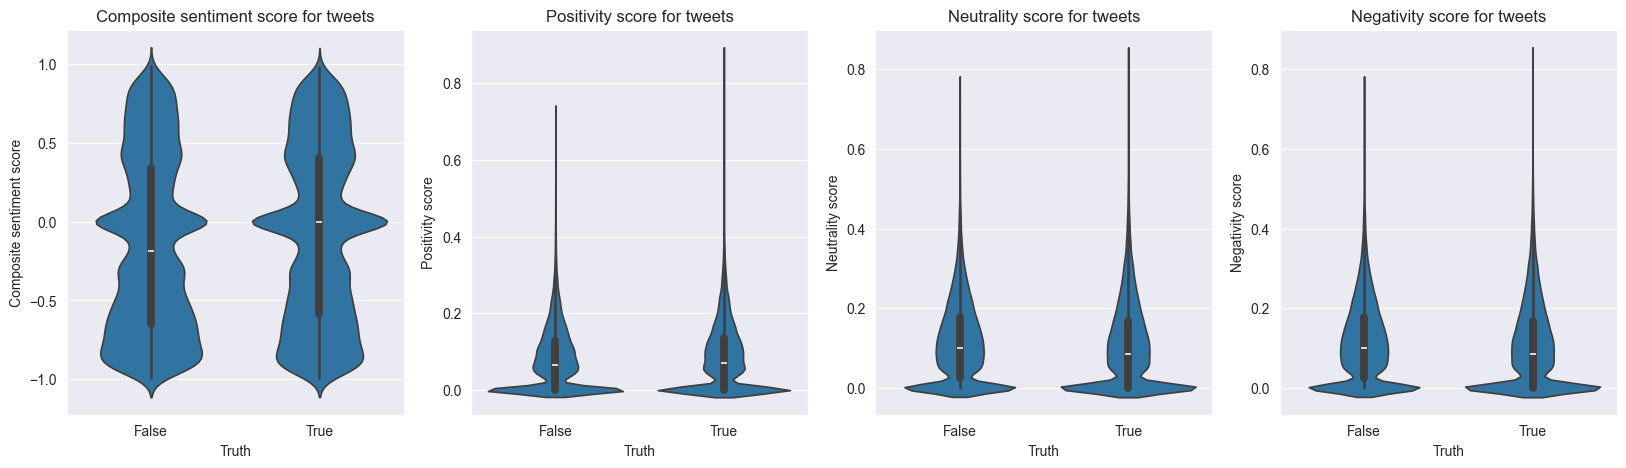

In [90]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
sns.violinplot(data=df, x='tweet_truth', y='sentiment', ax=ax1)
ax1.set_xlabel('Truth')
ax1.set_ylabel('Composite sentiment score')
ax1.set_title('Composite sentiment score for tweets')
sns.violinplot(data=df, x='tweet_truth', y='positivity', ax=ax2)
ax2.set_xlabel('Truth')
ax2.set_ylabel('Positivity score')
ax2.set_title('Positivity score for tweets')
sns.violinplot(data=df, x='tweet_truth', y='neutrality', ax=ax3)
ax3.set_xlabel('Truth')
ax3.set_ylabel('Neutrality score')
ax3.set_title('Neutrality score for tweets')
sns.violinplot(data=df, x='tweet_truth', y='negativity', ax=ax4)
ax4.set_xlabel('Truth')
ax4.set_ylabel('Negativity score')
ax4.set_title('Negativity score for tweets')
plt.show()

The most pronounced difference is in the composite score plot, where it's clear that the true tweets tend to have a more positive sentiment than the false tweets. Furthermore, the positivity scores for true tweets are generally slightly higher than for false tweets, the neutrality scores for false tweets are generally slightly higher than for true tweets (although a greater proportion of true tweets are neutral overall than false tweets), and the negativity scores for false tweets are generally slightly higher than for true tweets.

The final analysis I'm doing in this notebook is the relationship between influence and sentiment. There are multiple studies supporting the idea that tweets with negative sentiment spread faster than tweets with positive sentiment. I wanted to approximate this concept of spread with the dataset's built in normalized user influence score.

To make the data easier to visualize, I've binned the composite sentiment score into negative, neutral, and positive qualifiers. Tweets with scores between -0.25 and 0.25 were classified as neutral, and the others were classified by their sign.

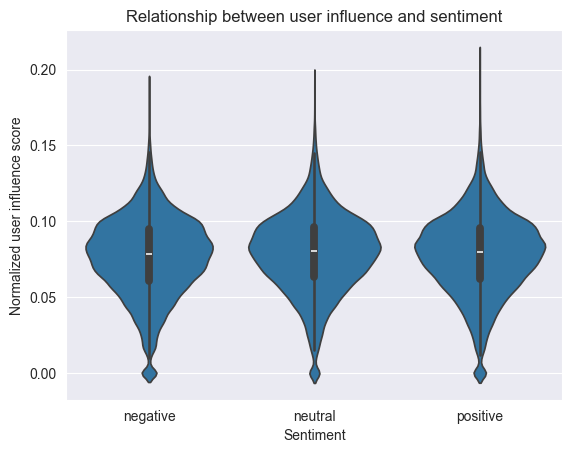

In [91]:
df['ternary_sentiment'] = 'positive'
df.loc[df.sentiment < -0.25, 'ternary_sentiment'] = 'negative'
df.loc[(-0.25 < df.sentiment) & (df.sentiment < 0.25), 'ternary_sentiment'] = 'neutral'
df['ternary_sentiment'] = df['ternary_sentiment'].astype('category').cat.reorder_categories(['negative', 'neutral', 'positive'])
fig, ax = plt.subplots()
sns.violinplot(data=df, x='ternary_sentiment', y='normalized_influence', ax=ax)
ax.set_xlabel('Sentiment')
ax.set_ylabel('Normalized user influence score')
ax.set_title('Relationship between user influence and sentiment')
plt.show()

This plot demonstrates that there is not much of a relationship between user influence and tweet sentiment, although if you look closely you can see that the median user influence score for negative tweets is marginally less than the median user influence score for the other categories. One would hope that negative tweets had less influence because of how they can trigger a negative response in a reader, but the lack of a relationship in this plot does not support this conclusion.

I should note that this particular metric for "spread" may not be optimal: just because a user has little influence doesn't mean they won't have a single tweet go viral, and not all tweets by influencers become popular.

## Conclusion

Many of the tweets in this dataset have to do with U.S. politics. A typical false tweet uses more alarming language, use capital letters more frequently, and has more negative sentiment than a true tweet; true tweets tend to be more neutral or positive in their language. For example, use of names of countries or nationalities is more associated with true tweets than with false tweets. Additionally, there appears to be little association between user influence and tweet sentiment.

The naive Bayes classifier used was quite effective at picking up on tone in statements to determine whether they sound like real or fake news, but was limited because it could not understand the input statements.

In the future, I'd like to try to incorporate capitalization, sentiment, or information source into a fake news classifier as all of these seem significant. To better quantify tweet spread, I'd also like to incorporate overall engagement data (favorites, retweets, quote tweets, etc.) or even try to graphically model virality with an influencer network. 
 
One question in particular that I wasn't able to answer with this dataset is what language people use to trick others into believing fake news. I could infer which false tweets trick people the most with engagement data, but ideally more data would be needed.

If I had more time, I would have liked to incorporate spaCy part-of-speech/word role tagging into my analysis. I observed that true tweets tend to use more location names, and spaCy tags would allow me to make that determination more conclusively. I would also want to analyze word complexity/readability and how it differs between true and false tweets.

Finally, one major limitation of this analysis is that all of this data was created before Elon Musk locked down the Twitter/X API with a major paywall. If it were possible to access the API without significant payment, it would be interesting to see how X Verified plays a role in the analyses I've performed here, if the language used by false and true tweets has changed, and how differences in influence and sentiment have changed.